# Car Price Prediction Model
___
*A Capstone Project by Meylis Garryyev (June 2020)*

This is the 2nd notebook of my capstone project.

## Part 1: Cleaning and Exploratory Data Analysis

Before starting working on our project, let's actually import python packages and libraries that we will be working with. In this notebook we will be working with Neural Networks run on Google's Colab space.

The cleaning and EDA procedures are exactly same as in the 1st notebook, but the `paint_color` column will be dropped before we start modelling (the reason was explained in the 1st notebook).

In [1]:
# Importing Python packages:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as mae

# Models used:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neural_network import MLPRegressor

# Displaying Tensorflow version:
print(tf.__version__)

#Some of these packages will generate a ton of warnings...
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0


Let's first start with importing our dataset file. The dataset was acquired from Kaggle, and is being updated every few months. The dataset that is used in this notebook is Version 5, is the [source](https://www.kaggle.com/austinreese/craigslist-carstrucks-data).

In [2]:
# Loading the file as dataframe:
# df_raw = pd.read_csv('data/vehicles.csv') - for loading from local drive

# Loading the file as dataframe from the Google Drive:
from google.colab import drive
drive.mount('/content/drive')

df_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/vehicles.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Let's see the shape of our dataset:
print('Shape of the dataset: ', df_raw.shape)

# The head of the dataset:
df_raw.head()

Shape of the dataset:  (539759, 25)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7088746062,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,10299,2012.0,acura,tl,NaN,NaN,gas,90186.0,clean,automatic,19UUA8F22CA003926,NaN,NaN,other,blue,https://images.craigslist.org/01414_3LIXs9EO33...,2012 Acura TL Base 4dr Sedan Offered by: B...,NaN,nc,35.7636,-78.7443
1,7088745301,https://greensboro.craigslist.org/ctd/d/bmw-3-...,greensboro,https://greensboro.craigslist.org,0,2011.0,bmw,335,NaN,6 cylinders,gas,115120.0,clean,automatic,NaN,rwd,NaN,convertible,blue,https://images.craigslist.org/00S0S_1kTatLGLxB...,BMW 3 Series 335i Convertible Navigation Dakot...,NaN,nc,NaN,NaN
2,7088744126,https://greensboro.craigslist.org/cto/d/greens...,greensboro,https://greensboro.craigslist.org,9500,2011.0,jaguar,xf,excellent,NaN,gas,85000.0,clean,automatic,NaN,NaN,NaN,NaN,blue,https://images.craigslist.org/00505_f22HGItCRp...,2011 jaguar XF premium - estate sale. Retired ...,NaN,nc,36.1032,-79.8794
3,7088743681,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,3995,2004.0,honda,element,NaN,NaN,gas,212526.0,clean,automatic,5J6YH18314L006498,fwd,NaN,SUV,orange,https://images.craigslist.org/00E0E_eAUnhFF86M...,2004 Honda Element LX 4dr SUV Offered by: ...,NaN,nc,35.7636,-78.7443
4,7074612539,https://lincoln.craigslist.org/ctd/d/gretna-20...,lincoln,https://lincoln.craigslist.org,41988,2016.0,chevrolet,silverado k2500hd,NaN,NaN,gas,NaN,clean,automatic,1GC1KWE85GF266427,NaN,NaN,NaN,NaN,https://images.craigslist.org/00S0S_8msT7RQquO...,"Shop Indoors, Heated Showroom!!!www.gretnaauto...",NaN,ne,41.1345,-96.2458


As we can see, our dataset consist of 539,759 rows and 25 columns, where each row represents each unique craigslist vehicle ad.

In [4]:
# Let's just get some more useful insights from our dataset:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539759 entries, 0 to 539758
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            539759 non-null  int64  
 1   url           539759 non-null  object 
 2   region        539759 non-null  object 
 3   region_url    539759 non-null  object 
 4   price         539759 non-null  int64  
 5   year          538772 non-null  float64
 6   manufacturer  516175 non-null  object 
 7   model         531746 non-null  object 
 8   condition     303707 non-null  object 
 9   cylinders     321264 non-null  object 
 10  fuel          536366 non-null  object 
 11  odometer      440783 non-null  float64
 12  title_status  536819 non-null  object 
 13  transmission  535786 non-null  object 
 14  vin           315349 non-null  object 
 15  drive         383987 non-null  object 
 16  size          168550 non-null  object 
 17  type          392290 non-null  object 
 18  pain

We can see that `county` column is actually a null column, no data is in it. So, let's remove it. But first, let's create a working copy of our raw dataframe.

In [5]:
# Creating a copy of the raw dataframe:
df_work1 = df_raw.copy()

# Dropping 'county' column:
df_work1 = df_work1.drop(['county'], axis=1)
df_work1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539759 entries, 0 to 539758
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            539759 non-null  int64  
 1   url           539759 non-null  object 
 2   region        539759 non-null  object 
 3   region_url    539759 non-null  object 
 4   price         539759 non-null  int64  
 5   year          538772 non-null  float64
 6   manufacturer  516175 non-null  object 
 7   model         531746 non-null  object 
 8   condition     303707 non-null  object 
 9   cylinders     321264 non-null  object 
 10  fuel          536366 non-null  object 
 11  odometer      440783 non-null  float64
 12  title_status  536819 non-null  object 
 13  transmission  535786 non-null  object 
 14  vin           315349 non-null  object 
 15  drive         383987 non-null  object 
 16  size          168550 non-null  object 
 17  type          392290 non-null  object 
 18  pain

Now, let's see if we have any duplicate rows.

In [6]:
# Let's see number of duplicate rows we have:
df_work1.duplicated().sum()

0

We can see that we don't have any duplicated rows. But is that really the case? Probably not, because we have some unique value columns in our dataset, like url's that were created for each ad, even if the ad was re-posted.

Let's actually remove some those columns (`id`,  `url`, `region_url`, `image_url`), which we won't be using for our model, as they probably won't make any useful impact on our model, but would take our computational capability. After dropping those, let's then check if we still have no duplicated rows.

In [7]:
# Dropping unnecessary columns:
df_work1 = df_work1.drop(['id', 'url', 'region_url', 'image_url'], axis=1)

# Let's see number of duplicate rows we have now:
df_work1.duplicated().sum()

37043

Now, as we can see, we have actually some duplicated rows. These were probably same ads posted few times. Let's remove them.

In [8]:
# Let's drop duplicate rows:
df_work1 = df_work1.drop_duplicates()

# Let's see number of duplicate rows we have:
df_work1.duplicated().sum()

0

We can see now that there are no duplicated rows left in our dataset.

We also don't really need the `vin` column, for the same reason as it this feature won't make much of a useful impact on our model. Additionally, we would also exclude `state` and `region` columns, as we would use `lat` and `long` columns instead. This would allow us to have much less columns at the end (saves computational load), as we won't have to turn `state` and `region` columns into binary columns, and we would have even more precise geographical information with `lat` and `long` columns.  Also, the `description` column will not be included for now, as it's a separate NLP problem, which is out of the scope of our project for now. So, let's drop those too.

Dropping `paint_color` too (reason explained in the 1st notebook).

In [9]:
# Dropping columns stated above:
df_work2 = df_work1.drop(['vin', 'description', 'region', 'state', 'paint_color'], axis=1)
df_work2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502716 entries, 0 to 539758
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         502716 non-null  int64  
 1   year          501764 non-null  float64
 2   manufacturer  481335 non-null  object 
 3   model         495471 non-null  object 
 4   condition     283533 non-null  object 
 5   cylinders     300806 non-null  object 
 6   fuel          499504 non-null  object 
 7   odometer      415131 non-null  float64
 8   title_status  500059 non-null  object 
 9   transmission  498747 non-null  object 
 10  drive         360334 non-null  object 
 11  size          158068 non-null  object 
 12  type          370108 non-null  object 
 13  lat           494033 non-null  float64
 14  long          494033 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 61.4+ MB


Before we begin exploring our data, let's check if we have any empty values and replace those with null values.

In [10]:
# Let's check if we have rows with empty values, and replace those empty values with NaN values:
df_work2 = df_work2.replace({'':np.nan})

Now, let's explore our numerical columns distributions.

In [11]:
# View distribution range of numerical columns:
df_work2.describe()

,price,year,odometer,lat,long
count,5.027160e+05,501764.000000,4.151310e+05,494033.000000,494033.000000
mean,2.013242e+05,2009.804105,1.003181e+05,38.413751,-94.046993
std,2.268544e+07,9.277610,1.801603e+05,5.890140,17.599488
min,0.000000e+00,0.000000,0.000000e+00,-84.911400,-176.810000
25%,4.495000e+03,2007.000000,4.635800e+04,34.186400,-107.368000
50%,9.840000e+03,2012.000000,9.252000e+04,39.045500,-88.066500
75%,1.799500e+04,2015.000000,1.370500e+05,42.449000,-81.282700
max,4.294967e+09,2021.000000,6.480922e+07,84.514800,161.016000


Having some knowledge about cars, we know that it's extremely unlikely that someone would sell a car for \\$0 or very small amount. Also, some of the ads would include car parts wrongly (or maybe intentionally) posted in the car sales section. Besides that, we can also see some extremely high numbers for the price. Those were probably are fake prices.

So, to be avoid having wrong data in our dataset and to address skewness, let's look at and remove rows with a price of \\$0 to \\$500, and also price of more than \\$100,000, as those would be outliers.

In [12]:
# Looking at how many cars are advertised at the price of $500 or less, and $1000,000 or more:
print('Number of rows with a price of $500 or less =', df_work2['price'][df_work2['price'] <= 500.0].count())
print('Number of rows with a price of $100,000 or more =', df_work2['price'][df_work2['price'] >= 100000.0].count())

Number of rows with a price of $500 or less = 49617
Number of rows with a price of $100,000 or more = 490


We can see that 49,617 cars were advertised at the price of \\$500 or less, and 490 cars were advertised at the price of \\$100,000 or more.

In [13]:
# Let's now drop those:
df_work2.drop(df_work2.loc[df_work2['price']<=500].index, inplace=True)
df_work2.drop(df_work2.loc[df_work2['price']>=100000].index, inplace=True)

After initial filtering of our `price` column, let's view the distribution of it and see if we still have skewness left. 

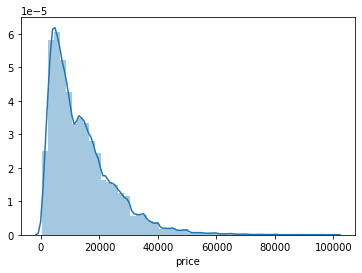

In [14]:
# Let's look at the distribution of the "price" column:
sns.distplot(df_work2["price"])

We can clearly see here that there are still some outliers. Ideally, I would like to set an upper price range of \\$40,000, and that would probably give me better model results. But due to my further plan of implementing this model into a website, and my intent to run tree based models, which we know won't be able to predict prices they haven't "seen", I decided to scope my price range up to \\$50,000. 

Number of rows with a price of $500 or less = 0
Number of rows with a price of $50,000 or more = 0


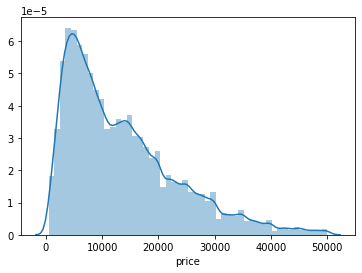

In [15]:
# Let's now drop those:
df_work2.drop(df_work2.loc[df_work2['price']>=50000].index, inplace=True)

# Double check if the values were dropped:
print('Number of rows with a price of $500 or less =', df_work2['price'][df_work2['price'] <= 500.0].count())
print('Number of rows with a price of $50,000 or more =', df_work2['price'][df_work2['price'] >= 50000.0].count())

# Let's look at the distribution of the "price" column:
sns.distplot(df_work2["price"])

Let's further explore our data.

In [16]:
# Let's see how many unique values each of the columns have:
df_work2.nunique(axis=0)

price            16582
year               111
manufacturer        42
model            34294
condition            6
cylinders            8
fuel                 5
odometer        114264
title_status         6
transmission         3
drive                3
size                 4
type                13
lat              53131
long             53155
dtype: int64

We can see that we have 34,294 unique values in our categorical `model` column. Converting them into dummy variables would take too many columns and would limit computational ability. I decided to drop this column.

In [17]:
# Dropping 'model' column:
df_work2 = df_work2.drop(['model'], axis=1)
df_work2.nunique(axis=0)

price            16582
year               111
manufacturer        42
condition            6
cylinders            8
fuel                 5
odometer        114264
title_status         6
transmission         3
drive                3
size                 4
type                13
lat              53131
long             53155
dtype: int64

We can see that the number of unique years is 111. Let's actually explore our `year` column.

In [18]:
# Looking at our 'year' column:
df_work2.describe()

,price,year,odometer,lat,long
count,447936.000000,447143.000000,3.716510e+05,444255.000000,444255.000000
mean,13494.169002,2009.452262,1.033392e+05,38.443925,-93.740187
std,9843.242874,9.376574,1.873337e+05,5.892406,17.429466
min,503.000000,0.000000,0.000000e+00,-84.911400,-176.810000
25%,5800.000000,2006.000000,4.964550e+04,34.221850,-106.286500
50%,10995.000000,2011.000000,9.576700e+04,39.123400,-87.931700
75%,18900.000000,2015.000000,1.400000e+05,42.449100,-81.143300
max,49999.000000,2021.000000,6.480922e+07,84.514800,161.016000


We can see from here that the min value for our `year` column is 0, and the max value is 2021 (data was scraped from Craigslist in Feb 2020). These are not realistic values. Let's now actually see unique years in our dataset.

In [19]:
print(sorted(df_work2['year'].unique(), reverse=True))

[2019.0, 2018.0, 2017.0, 2016.0, 2015.0, 2014.0, 2013.0, 2012.0, 2011.0, 2010.0, 2009.0, 2008.0, 2007.0, 2006.0, 2005.0, 2004.0, 2003.0, 2002.0, 2001.0, 2000.0, 1999.0, 1998.0, 1997.0, 1996.0, 1995.0, 1994.0, 1993.0, 1992.0, 1991.0, 1990.0, 1989.0, 1988.0, 1987.0, 1986.0, 1985.0, 1984.0, 1983.0, 1981.0, 1980.0, 1979.0, 1977.0, 1975.0, 1974.0, 1973.0, 1972.0, 1971.0, 1970.0, 1968.0, 1967.0, 1966.0, 1964.0, 1951.0, 1950.0, 1949.0, 1942.0, 1929.0, nan, 2021.0, 2020.0, 1982.0, 1978.0, 1976.0, 1969.0, 1965.0, 1963.0, 1962.0, 1961.0, 1960.0, 1959.0, 1958.0, 1957.0, 1956.0, 1955.0, 1954.0, 1953.0, 1952.0, 1948.0, 1947.0, 1946.0, 1945.0, 1943.0, 1941.0, 1940.0, 1939.0, 1938.0, 1937.0, 1936.0, 1935.0, 1934.0, 1933.0, 1932.0, 1931.0, 1930.0, 1928.0, 1927.0, 1926.0, 1925.0, 1924.0, 1923.0, 1922.0, 1919.0, 1918.0, 1917.0, 1916.0, 1915.0, 1914.0, 1913.0, 1912.0, 1909.0, 1908.0, 1900.0, 0.0]


We can see that we have some NAN values too. Let's see how many we have.

In [20]:
# Let's see what percentage of each column has missing values, and sort in descending order:
(np.mean(df_work2.isna()).sort_values(ascending = False))*100

size            68.239659
condition       41.309026
cylinders       39.253375
drive           28.374143
type            26.689974
odometer        17.030335
manufacturer     3.959717
long             0.821769
lat              0.821769
transmission     0.734703
fuel             0.642949
title_status     0.510341
year             0.177034
price            0.000000
dtype: float64

We have only 0.18% null values in our `year` column. As this is a tiny percentage, it was decided to drop those null values.

In [21]:
# Dropping null values in 'year' column:
df_work2.dropna(subset=['year'], inplace=True)
(np.mean(df_work2.isna()).sort_values(ascending = False))*100

size            68.183333
condition       41.204939
cylinders       39.318294
drive           28.402323
type            26.717627
odometer        17.056288
manufacturer     3.789615
long             0.818977
lat              0.818977
transmission     0.731757
fuel             0.587508
title_status     0.441917
year             0.000000
price            0.000000
dtype: float64

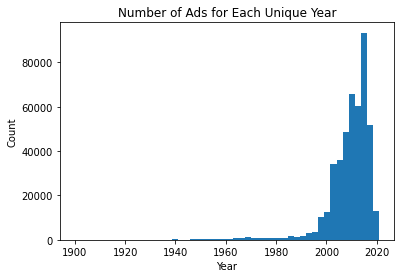

In [22]:
# Histogram of the years distribution:
plt.figure()
plt.hist(df_work2['year'], range=(1900,2021), bins=50)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Ads for Each Unique Year')
plt.show()

From the histogram above we can see that there were very few cars older than year of 1950 advertised. Let's exclude those outliers from our project scope. Again, here the scope was not too limited, as we could have set a lower range from 1980 or 1990 onwards, and get better results, but it was decided to have a higher range just for future plans of model implementation and the use of tree based models, as I have already described above.

In [23]:
# Let's now grab only years starting from 1950 and until current year of 2020:
df_work2 = df_work2[df_work2['year'].between(1950, 2020)]

# Let's just double check our years:
df_work2.describe()

,price,year,odometer,lat,long
count,446096.000000,446096.000000,3.705490e+05,442443.000000,442443.000000
mean,13457.875758,2009.620824,1.035323e+05,38.452336,-93.728282
std,9810.368517,8.183100,1.873696e+05,5.888064,17.426862
min,503.000000,1950.000000,0.000000e+00,-84.911400,-176.810000
25%,5800.000000,2006.000000,5.000000e+04,34.231600,-106.245000
50%,10995.000000,2011.000000,9.600000e+04,39.123400,-87.922700
75%,18900.000000,2015.000000,1.400100e+05,42.454400,-81.130300
max,49999.000000,2020.000000,6.480922e+07,84.514800,161.016000


From the above chart we can also see that our odometer column has some outliers too, with a min of 0 mileage, and max of really high values. For our project scope, we will use realistic mileages of used cars, from 50 to 300,000 odometer values.

In [24]:
# Let's now filter out odometer values from 50 to 300,000:
df_work2 = df_work2[df_work2['odometer'].between(50, 300000)]

# Let's just double check our odometer values:
df_work2.describe()

,price,year,odometer,lat,long
count,365752.000000,365752.000000,365752.000000,362854.000000,362854.000000
mean,14212.702235,2010.602682,99555.629749,38.635932,-93.915396
std,9797.012366,6.790377,59035.403243,5.759702,17.643886
min,503.000000,1950.000000,50.000000,-84.911400,-170.288000
25%,6490.000000,2007.000000,50467.000000,34.453025,-107.751500
50%,11999.000000,2012.000000,95959.500000,39.292800,-87.823200
75%,19800.000000,2015.000000,139728.000000,42.498600,-81.118200
max,49999.000000,2020.000000,300000.000000,84.514800,161.016000


In [25]:
# Let's see what percentage of each column has missing values left:
(np.mean(df_work2.isna()).sort_values(ascending = False))*100

size            66.221374
condition       37.884687
cylinders       34.756611
drive           21.008498
type            18.167501
manufacturer     2.867243
transmission     0.847569
long             0.792340
lat              0.792340
fuel             0.669033
title_status     0.520024
odometer         0.000000
year             0.000000
price            0.000000
dtype: float64

Let's actually see what unique values each of our non-numeric columns have, and how many of those values are there. Let's see if some of those columns already contain values like 'other' or 'unknown', so instead of dropping null values or assigning some biased values, we would just assign null rows into those values.  

In [26]:
for i in df_work2.select_dtypes(include = ['object']).columns:
    display(pd.DataFrame(df_work2[i].value_counts()))

,manufacturer
ford,66365
chevrolet,52856
toyota,28716
nissan,19809
honda,18282
ram,18197
jeep,17929
gmc,16258
dodge,12166
bmw,10814


,condition
excellent,103050
good,97446
like new,20188
fair,5652
new,469
salvage,383


,cylinders
6 cylinders,88184
8 cylinders,73262
4 cylinders,72511
5 cylinders,2185
10 cylinders,1349
other,622
3 cylinders,418
12 cylinders,98


,fuel
gas,321003
diesel,27706
other,10746
hybrid,3178
electric,672


,title_status
clean,348302
rebuilt,9116
salvage,3851
lien,2367
missing,160
parts only,54


,transmission
automatic,321549
manual,20892
other,20211


,drive
4wd,134077
fwd,102218
rwd,52618


,size
full-size,67691
mid-size,34369
compact,18426
sub-compact,3060


,type
sedan,73379
SUV,71856
pickup,44231
truck,35670
coupe,16561
other,13986
hatchback,12044
wagon,10043
van,8381
convertible,6923


As we can see from above, our `fuel` column has 0.67% of missing values, and it also has 'other' values. Let's assign our null values to be 'other':

In [27]:
# Filling in missing values in 'fuel' column:
df_work2['fuel'].fillna('other', inplace=True)

In [28]:
# Let's see what percentage of each column has missing values, and sort in descending order:
(np.mean(df_work2.isna()).sort_values(ascending = False))*100

size            66.221374
condition       37.884687
cylinders       34.756611
drive           21.008498
type            18.167501
manufacturer     2.867243
transmission     0.847569
long             0.792340
lat              0.792340
title_status     0.520024
odometer         0.000000
fuel             0.000000
year             0.000000
price            0.000000
dtype: float64

Same goes for `title_status` column which has label of 'missing'. Let's see the distribution and assign null values to be 'missing'.

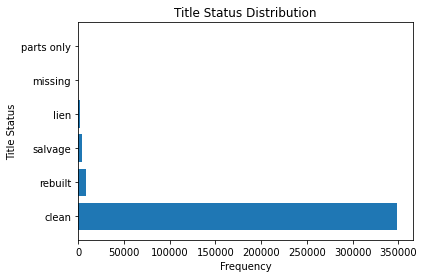

In [29]:
# See the distribution of unique values in the 'title_status' column:
plt.figure()
plt.barh(df_work2['title_status'].value_counts().index, 
         df_work2['title_status'].value_counts().values)
plt.title("Title Status Distribution")
plt.xlabel("Frequency")
plt.ylabel("Title Status")
plt.show()

In [30]:
# Filling in missing values in 'title_status' column:
df_work2['title_status'].fillna('missing', inplace=True)

# Double check what percentage of each column has missing values, and sort in descending order:
(np.mean(df_work2.isna()).sort_values(ascending = False))*100

size            66.221374
condition       37.884687
cylinders       34.756611
drive           21.008498
type            18.167501
manufacturer     2.867243
transmission     0.847569
long             0.792340
lat              0.792340
title_status     0.000000
odometer         0.000000
fuel             0.000000
year             0.000000
price            0.000000
dtype: float64

Let's do same with other valid columns too.

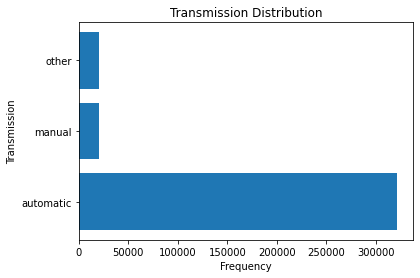

In [31]:
# See the distribution of unique values in the 'transmission' column:
plt.figure()
plt.barh(df_work2['transmission'].value_counts().index, 
         df_work2['transmission'].value_counts().values)
plt.title("Transmission Distribution")
plt.xlabel("Frequency")
plt.ylabel("Transmission")
plt.show()

In [32]:
# Filling in missing values in 'transmission' column:
df_work2['transmission'].fillna('other', inplace=True)

# Double check what percentage of each column has missing values, and sort in descending order:
(np.mean(df_work2.isna()).sort_values(ascending = False))*100

size            66.221374
condition       37.884687
cylinders       34.756611
drive           21.008498
type            18.167501
manufacturer     2.867243
long             0.792340
lat              0.792340
transmission     0.000000
title_status     0.000000
odometer         0.000000
fuel             0.000000
year             0.000000
price            0.000000
dtype: float64

We can also see here that the `size` column has more than 66% of missing values in it. This is too much, and if we impute them, it would introduce a lot of bias into our model. So, it was decide to drop this column.

In [33]:
# Dropping the 'size' column: 
df_work2 = df_work2.drop(['size'], axis=1)

# Double check what percentage of each column has missing values, and sort in descending order:
(np.mean(df_work2.isna()).sort_values(ascending = False))*100

condition       37.884687
cylinders       34.756611
drive           21.008498
type            18.167501
manufacturer     2.867243
long             0.792340
lat              0.792340
transmission     0.000000
title_status     0.000000
odometer         0.000000
fuel             0.000000
year             0.000000
price            0.000000
dtype: float64

Let's see the distribution of values in the remaining missing value columns. 

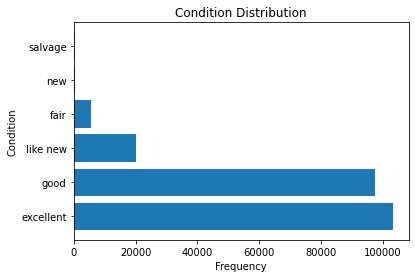

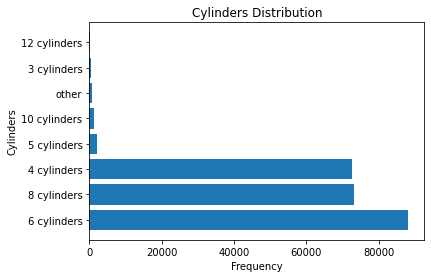

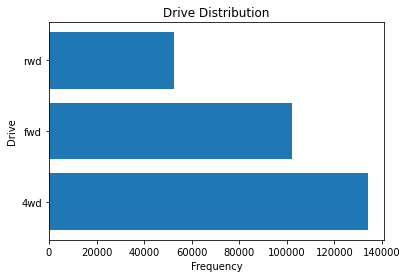

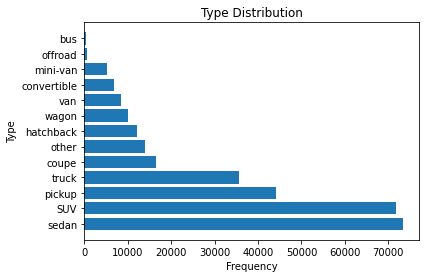

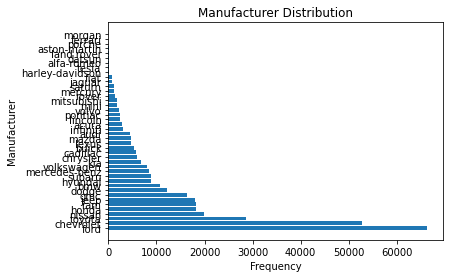

In [34]:
# See the distribution of unique values in the 'condition' column:
plt.figure()
plt.barh(df_work2['condition'].value_counts().index, 
         df_work2['condition'].value_counts().values)
plt.title("Condition Distribution")
plt.xlabel("Frequency")
plt.ylabel("Condition")
plt.show();

# See the distribution of unique values in the 'cylinders' column:
plt.figure()
plt.barh(df_work2['cylinders'].value_counts().index, 
         df_work2['cylinders'].value_counts().values)
plt.title("Cylinders Distribution")
plt.xlabel("Frequency")
plt.ylabel("Cylinders")
plt.show();

# See the distribution of unique values in the 'drive' column:
plt.figure()
plt.barh(df_work2['drive'].value_counts().index, 
         df_work2['drive'].value_counts().values)
plt.title("Drive Distribution")
plt.xlabel("Frequency")
plt.ylabel("Drive")
plt.show();

# See the distribution of unique values in the 'type' column:
plt.figure()
plt.barh(df_work2['type'].value_counts().index, 
         df_work2['type'].value_counts().values)
plt.title("Type Distribution")
plt.xlabel("Frequency")
plt.ylabel("Type")
plt.show();

# See the distribution of unique values in the 'manufacturer' column:
plt.figure()
plt.barh(df_work2['manufacturer'].value_counts().index, 
         df_work2['manufacturer'].value_counts().values)
plt.title("Manufacturer Distribution")
plt.xlabel("Frequency")
plt.ylabel("Manufacturer")
plt.show();

As we can see from the distribution charts above, we have few dominant values in each column, thus, assigning missing values as the most frequent value within the column would actually impose bias towards our model, especially when we the percentage of missing values is high (from 18% to 38%). Thus, it was decided to assign those missing values as a separate value. 

In [35]:
# Filling in missing values with new 'missing' name:
df_work2['condition'].fillna('missing', inplace=True)
df_work2['cylinders'].fillna('missing', inplace=True)
df_work2['drive'].fillna('missing', inplace=True)
df_work2['type'].fillna('missing', inplace=True)
df_work2['manufacturer'].fillna('missing', inplace=True)

# Double check what percentage of each column has missing values, and sort in descending order:
(np.mean(df_work2.isna()).sort_values(ascending = False))*100

long            0.79234
lat             0.79234
type            0.00000
drive           0.00000
transmission    0.00000
title_status    0.00000
odometer        0.00000
fuel            0.00000
cylinders       0.00000
condition       0.00000
manufacturer    0.00000
year            0.00000
price           0.00000
dtype: float64

In [36]:
# Let's drop na values of lat and long columns, as they are less than 1%:
df_work2.dropna(subset=['lat'], inplace=True)
df_work2.dropna(subset=['long'], inplace=True)

# Double check what percentage of each column has missing values, and sort in descending order:
(np.mean(df_work2.isna()).sort_values(ascending = False))*100

long            0.0
lat             0.0
type            0.0
drive           0.0
transmission    0.0
title_status    0.0
odometer        0.0
fuel            0.0
cylinders       0.0
condition       0.0
manufacturer    0.0
year            0.0
price           0.0
dtype: float64

In [37]:
# Let's take a quick look at the correlation between our columns:
df_work2.corr().style.background_gradient()

,price,year,odometer,lat,long
price,1.000000,0.478164,-0.517035,0.036000,-0.149115
year,0.478164,1.000000,-0.466989,-0.003752,-0.017337
odometer,-0.517035,-0.466989,1.000000,0.026567,0.042387
lat,0.036000,-0.003752,0.026567,1.000000,-0.168342
long,-0.149115,-0.017337,0.042387,-0.168342,1.000000


From the correlation chart above, we can state that there is a strong positive correlation between `year` and `price`, which mean that the higher the year value, the higher would the price be. Also, there is a strong negative correlation between the `odometer` feature and the `price` value, meaning that with higher mileage distance, the price would be lower. Also, there is a negative correlation between `year` and `odometer` features, implying that the newer the car (higher year value) the less mileage it would have. All these correlations make sense realistically too.

We won't go deeply in exploring all these correlations, instead, we will explore the feature importance values after running some ml models later.

Now, after cleaning our dataset, let's convert our categorical features into numerical, so that we could run our models.

In [38]:
# Let's now convert our categorical columns into dummy variables:
df_work3 = pd.get_dummies(df_work2)

# Let's reset index, and remove all the spaces within column names and make them all lowercase (in case if there are some uppercase letters):
df_work3.columns = df_work3.columns.str.replace(' ', '_')
df_work3.columns = map(str.lower, df_work3.columns)

# Resetting index:
df_work3 = df_work3.reset_index().drop(columns = ['index']).copy()
print('The shape of our new dataframe is: ', df_work3.shape)
print()
df_work3.head()

The shape of our new dataframe is:  (362854, 96)



,price,year,odometer,lat,long,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land_rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_missing,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porche,...,cylinders_12_cylinders,cylinders_3_cylinders,cylinders_4_cylinders,cylinders_5_cylinders,cylinders_6_cylinders,cylinders_8_cylinders,cylinders_missing,cylinders_other,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,title_status_clean,title_status_lien,title_status_missing,title_status_parts_only,title_status_rebuilt,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_missing,drive_rwd,type_suv,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_missing,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
0,10299,2012.0,90186.0,35.7636,-78.7443,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,9500,2011.0,85000.0,36.1032,-79.8794,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,3995,2004.0,212526.0,35.7636,-78.7443,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12995,2015.0,85127.0,35.7636,-78.7443,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,10995,2014.0,112383.0,35.7636,-78.7443,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we have our clean processed dataframe. Let's move onto the modelling part.

Again, please note, that this notebook will focus only on the Neural Network modelling part. The 1st notebook runs through all other ScikitLearn and XGBoost regression models.

## Part 2: Modelling

### 2.12. MLP Regression

In [79]:
# ScikitLearn MLP Regression (default values):

# Assigning data (X) and target (y) columns:
X_mlp = df_work3.loc[:, df_work3.columns != 'price']
y_mlp = df_work3['price']

print('X_mlp shape:', X_mlp.shape)
print('y_mlp shape:', y_mlp.shape)

# Let's split our dataframe into train and test sets:
X_mlp_train, X_mlp_test, y_mlp_train, y_mlp_test = train_test_split(X_mlp, y_mlp, test_size = 0.2, random_state=1)

print('X_mlp_train shape:', X_mlp_train.shape)
print('y_mlp_train shape:', y_mlp_train.shape)
print('X_mlp_test shape:', X_mlp_test.shape)
print('y_mlp_test shape:', y_mlp_test.shape)
print("------------------------------------------------------------------------------------------------------------")

# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_mlp_train)
X_mlp_train = scaler.transform(X_mlp_train)
X_mlp_test = scaler.transform(X_mlp_test)

# 1. Instantiate the model:
myMLP = MLPRegressor()

# 2. Fit the model:
myMLP.fit(X_mlp_train, y_mlp_train)

# 3. Make prediction (will use it for mae):
y_mlp_test_pred = myMLP.predict(X_mlp_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_mlp_test, y_mlp_test_pred))
print("The mean value of the price column is: ", y_mlp_test.mean())
print("The train set R^2 of our model is: ", round(myMLP.score(X_mlp_train,y_mlp_train),4))
print("The test set R^2 of our model is: ", round(myMLP.score(X_mlp_test,y_mlp_test),4))

X_mlp shape: (362854, 95)
y_mlp shape: (362854,)
X_mlp_train shape: (290283, 95)
y_mlp_train shape: (290283,)
X_mlp_test shape: (72571, 95)
y_mlp_test shape: (72571,)
------------------------------------------------------------------------------------------------------------
The mean absolute error of our model is:  2674.2216117688467
The mean value of the price column is:  14254.943448484932
The train set R^2 of our model is:  0.8311
The test set R^2 of our model is:  0.8284


We can see that the R^2 score and MAE values are lower than that of RandomForestRegressor and XGBRegressor models, that were run in the 1st notebook.

In [80]:
# Here are our model default values:
myMLP

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

Let's now try different parameters and see if we can improve results from the default MLPRegressor model.

In [83]:
# ScikitLearn MLP Regression (customized parameters):

# Assigning data (X) and target (y) columns:
X_mlp = df_work3.loc[:, df_work3.columns != 'price']
y_mlp = df_work3['price']

print('X_mlp shape:', X_mlp.shape)
print('y_mlp shape:', y_mlp.shape)

# Let's split our dataframe into train and test sets:
X_mlp_train, X_mlp_test, y_mlp_train, y_mlp_test = train_test_split(X_mlp, y_mlp, test_size = 0.2, random_state=1)

print('X_mlp_train shape:', X_mlp_train.shape)
print('y_mlp_train shape:', y_mlp_train.shape)
print('X_mlp_test shape:', X_mlp_test.shape)
print('y_mlp_test shape:', y_mlp_test.shape)
print("------------------------------------------------------------------------------------------------------------")

# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_mlp_train)
X_mlp_train = scaler.transform(X_mlp_train)
X_mlp_test = scaler.transform(X_mlp_test)

# 1. Instantiate the model:
myMLP = MLPRegressor(max_iter=1000, random_state=1, early_stopping=True, n_iter_no_change=50)

# 2. Fit the model:
myMLP.fit(X_mlp_train, y_mlp_train)

# 3. Make prediction (will use it for mae):
y_mlp_test_pred = myMLP.predict(X_mlp_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_mlp_test, y_mlp_test_pred))
print("The mean value of the price column is: ", y_mlp_test.mean())
print("The train set R^2 of our model is: ", round(myMLP.score(X_mlp_train,y_mlp_train),4))
print("The test set R^2 of our model is: ", round(myMLP.score(X_mlp_test,y_mlp_test),4))

X_mlp shape: (362854, 95)
y_mlp shape: (362854,)
X_mlp_train shape: (290283, 95)
y_mlp_train shape: (290283,)
X_mlp_test shape: (72571, 95)
y_mlp_test shape: (72571,)
------------------------------------------------------------------------------------------------------------
The mean absolute error of our model is:  2672.6555608880376
The mean value of the price column is:  14254.943448484932
The train set R^2 of our model is:  0.8303
The test set R^2 of our model is:  0.8282


We still got same result. Let's try adjusting another parameter. 

In [84]:
# ScikitLearn MLP Regression (customized parameters, learning rate='adaptive'):

# Assigning data (X) and target (y) columns:
X_mlp = df_work3.loc[:, df_work3.columns != 'price']
y_mlp = df_work3['price']

print('X_mlp shape:', X_mlp.shape)
print('y_mlp shape:', y_mlp.shape)

# Let's split our dataframe into train and test sets:
X_mlp_train, X_mlp_test, y_mlp_train, y_mlp_test = train_test_split(X_mlp, y_mlp, test_size = 0.2, random_state=1)

print('X_mlp_train shape:', X_mlp_train.shape)
print('y_mlp_train shape:', y_mlp_train.shape)
print('X_mlp_test shape:', X_mlp_test.shape)
print('y_mlp_test shape:', y_mlp_test.shape)
print("------------------------------------------------------------------------------------------------------------")

# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_mlp_train)
X_mlp_train = scaler.transform(X_mlp_train)
X_mlp_test = scaler.transform(X_mlp_test)

# 1. Instantiate the model:
myMLP = MLPRegressor(learning_rate='adaptive', max_iter=1000, random_state=1, early_stopping=True, n_iter_no_change=50)

# 2. Fit the model:
myMLP.fit(X_mlp_train, y_mlp_train)

# 3. Make prediction (will use it for mae):
y_mlp_test_pred = myMLP.predict(X_mlp_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_mlp_test, y_mlp_test_pred))
print("The mean value of the price column is: ", y_mlp_test.mean())
print("The train set R^2 of our model is: ", round(myMLP.score(X_mlp_train,y_mlp_train),4))
print("The test set R^2 of our model is: ", round(myMLP.score(X_mlp_test,y_mlp_test),4))

X_mlp shape: (362854, 95)
y_mlp shape: (362854,)
X_mlp_train shape: (290283, 95)
y_mlp_train shape: (290283,)
X_mlp_test shape: (72571, 95)
y_mlp_test shape: (72571,)
------------------------------------------------------------------------------------------------------------
The mean absolute error of our model is:  2672.6555608880376
The mean value of the price column is:  14254.943448484932
The train set R^2 of our model is:  0.8303
The test set R^2 of our model is:  0.8282


Still no improvement. Let's now move onto our Keras model.

### 2.13. Keras

In [39]:
# Assigning data (X) and target (y) columns:
X_train = df_work3.sample(frac=0.8,random_state=1)
X_test = df_work3.drop(X_train.index)

y_train = X_train.pop('price')
y_test = X_test.pop('price')

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print("-------------------------------------------------------------------------------------------------------------")

# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Transform numpy.ndarray back to dataframe:
X_train_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print('X_train_df shape:', X_train_df.shape)
print('X_test_df shape:', X_test_df.shape)
X_train_df.head()

X_train shape: (290283, 95)
X_test shape: (72571, 95)
y_train shape: (290283,)
y_test shape: (72571,)
-------------------------------------------------------------------------------------------------------------
X_train_df shape: (290283, 95)
X_test_df shape: (72571, 95)


,year,odometer,lat,long,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land_rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_missing,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porche,manufacturer_ram,...,cylinders_12_cylinders,cylinders_3_cylinders,cylinders_4_cylinders,cylinders_5_cylinders,cylinders_6_cylinders,cylinders_8_cylinders,cylinders_missing,cylinders_other,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,title_status_clean,title_status_lien,title_status_missing,title_status_parts_only,title_status_rebuilt,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_missing,drive_rwd,type_suv,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_missing,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
274246,-1.568276,1.472105,-0.254476,-1.115685,-0.089426,-0.012993,-0.007189,-0.11092,-0.174007,-0.120828,-0.125866,2.423302,-0.127382,-0.007653,-0.185665,-0.002625,-0.044667,-0.469686,-0.215408,-0.020672,-0.229656,-0.15817,-0.091727,-0.04741,-0.226757,-0.137717,-0.006945,-0.115094,-0.082174,-0.11322,-0.153638,-0.058083,-0.072192,-0.171575,-0.070902,0.0,-0.239802,-0.080087,-0.00525,-0.229573,...,-0.016707,-0.034193,-0.495843,-0.077745,1.777548,-0.500282,-0.732655,-0.039839,-0.286657,-0.042362,0.373491,-0.093468,-0.193341,0.22426,-0.081191,-0.075723,-0.012452,-0.159833,-0.103353,0.371188,-0.246092,-0.261472,-0.760456,-0.622607,-0.516621,2.442348,-0.494274,-0.033064,-0.138636,4.573267,-0.185207,-0.120799,-0.471935,-0.03874,-0.194317,-0.370911,-0.502084,-0.329734,-0.152825,-0.167652
209009,0.056912,0.611070,1.250287,0.390028,-0.089426,-0.012993,-0.007189,-0.11092,-0.174007,-0.120828,-0.125866,-0.412660,-0.127382,-0.007653,-0.185665,-0.002625,-0.044667,2.129083,-0.215408,-0.020672,-0.229656,-0.15817,-0.091727,-0.04741,-0.226757,-0.137717,-0.006945,-0.115094,-0.082174,-0.11322,-0.153638,-0.058083,-0.072192,-0.171575,-0.070902,0.0,-0.239802,-0.080087,-0.00525,-0.229573,...,-0.016707,-0.034193,2.016767,-0.077745,-0.562573,-0.500282,-0.732655,-0.039839,-0.286657,-0.042362,0.373491,-0.093468,-0.193341,0.22426,-0.081191,-0.075723,-0.012452,-0.159833,-0.103353,0.371188,-0.246092,-0.261472,-0.760456,1.606150,-0.516621,-0.409442,-0.494274,-0.033064,-0.138636,-0.218662,-0.185207,-0.120799,-0.471935,-0.03874,-0.194317,-0.370911,1.991697,-0.329734,-0.152825,-0.167652
237307,-1.125043,0.451767,-0.661848,0.357032,-0.089426,-0.012993,-0.007189,-0.11092,-0.174007,-0.120828,-0.125866,2.423302,-0.127382,-0.007653,-0.185665,-0.002625,-0.044667,-0.469686,-0.215408,-0.020672,-0.229656,-0.15817,-0.091727,-0.04741,-0.226757,-0.137717,-0.006945,-0.115094,-0.082174,-0.11322,-0.153638,-0.058083,-0.072192,-0.171575,-0.070902,0.0,-0.239802,-0.080087,-0.00525,-0.229573,...,-0.016707,-0.034193,-0.495843,-0.077745,1.777548,-0.500282,-0.732655,-0.039839,-0.286657,-0.042362,0.373491,-0.093468,-0.193341,0.22426,-0.081191,-0.075723,-0.012452,-0.159833,-0.103353,0.371188,-0.246092,-0.261472,-0.760456,1.606150,-0.516621,-0.409442,-0.494274,-0.033064,-0.138636,4.573267,-0.185207,-0.120799,-0.471935,-0.03874,-0.194317,-0.370911,-0.502084,-0.329734,-0.152825,-0.167652
106456,1.091123,-1.028549,0.594862,-0.053229,-0.089426,-0.012993,-0.007189,-0.11092,-0.174007,-0.120828,-0.125866,-0.412660,-0.127382,-0.007653,-0.185665,-0.002625,-0.044667,-0.469686,-0.215408,-0.020672,-0.229656,-0.15817,-0.091727,-0.04741,-0

In [41]:
# Let's assign R^2 score calculation for Keras (source: https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score)
from keras import backend as K

def coeff_r2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

# Let's create a class to display the progress of our model with dots for each epoch:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.',end='')

Using TensorFlow backend.


In [90]:
# Creating function to define our model's parameters (simple model, with RMSprop optimizer):
def keras_model():
  model = keras.Sequential([                           
                            layers.Dense(95, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
                            layers.Dense(95, activation=tf.nn.relu),
                            layers.Dense(1)
                            ])
  my_optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=my_optimizer, metrics=['mae','mse', coeff_r2])
  
  return model

# Assigning our function to our model:
model = keras_model()

# Let's inspect the model:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 95)                9120      
_________________________________________________________________
dense_4 (Dense)              (None, 95)                9120      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 96        
Total params: 18,336
Trainable params: 18,336
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Let's now train our model (1000 epochs):
my_epochs = 1000

# Assigning early stop:
my_early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50) # setting early stopping for 50 epochs with no improve in val_loss

# Fitting our model:
history = model.fit(X_train_scaled, y_train, epochs=my_epochs, validation_split = 0.2, verbose=0, callbacks=[my_early_stop, PrintDot()])


....................................................

In [112]:
# Let's see the mean absolute error of test set (1000 epochs):
loss, mae, mse, r2 = model.evaluate(X_test_scaled, y_test, verbose=0)

print('The mean absolute error of our model is:', round(mae,2))
print('The mean value of the price column is: ', round(y_test.mean(),2))
print('The test set R^2 of our model is: ', round(r2,4))

The mean absolute error of our model is: 2532.01
The mean value of the price column is:  14204.42
The test set R^2 of our model is:  0.6862


Not the best R^2 score. Let's try to adjust some of our model's parameters.

In [107]:
# Let's try our model with 'adam' optimizer:
def keras_model2():
  model = keras.Sequential([                           
                            layers.Dense(95, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
                            layers.Dense(95, activation=tf.nn.relu),
                            layers.Dense(1)
                            ])
  model.compile(loss='mse', optimizer='adam', metrics=['mae','mse', coeff_r2])
  return model

# Assigning our function to our model:
model2 = keras_model2()

# Assigning number of epochs:
my_epochs = 1000

# Assigning early stop:
my_early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Fitting our model:
history = model2.fit(X_train_scaled, y_train, epochs=my_epochs, validation_split = 0.2, verbose=1, callbacks=[my_early_stop])

Epoch 1/1000
7258/7258 [==============================] - 15s 2ms/step - loss: 37541020.0000 - mae: 3933.6836 - mse: 37541020.0000 - coeff_r2: 0.5827 - val_loss: 21133244.0000 - val_mae: 3086.7339 - val_mse: 21133244.0000 - val_coeff_r2: 0.7655
Epoch 2/1000
7258/7258 [==============================] - 16s 2ms/step - loss: 19838458.0000 - mae: 2972.3865 - mse: 19838458.0000 - coeff_r2: 0.7761 - val_loss: 18949474.0000 - val_mae: 2901.6626 - val_mse: 18949474.0000 - val_coeff_r2: 0.7899
Epoch 3/1000
7258/7258 [==============================] - 16s 2ms/step - loss: 18435552.0000 - mae: 2855.7837 - mse: 18435552.0000 - coeff_r2: 0.7960 - val_loss: 18356560.0000 - val_mae: 2829.2214 - val_mse: 18356560.0000 - val_coeff_r2: 0.7964
Epoch 4/1000
7258/7258 [==============================] - 16s 2ms/step - loss: 18118994.0000 - mae: 2795.6206 - mse: 18118994.0000 - coeff_r2: 0.7935 - val_loss: 18560112.0000 - val_mae: 2782.5054 - val_mse: 18560112.0000 - val_coeff_r2: 0.7963
Epoch 5/1000
7258/72

In [111]:
# Let's see the mean absolute error of test set (with 'adam' optimizer):
loss, mae, mse, r2 = model2.evaluate(X_test_scaled, y_test, verbose=0)

print('The mean absolute error of our model is:', round(mae,2))
print('The mean value of the price column is: ', round(y_test.mean(),2))
print('The test set R^2 of our model is: ', round(r2,4))

The mean absolute error of our model is: 2451.24
The mean value of the price column is:  14204.42
The test set R^2 of our model is:  0.8313


We can clearly see improvement in our result when using 'adam' optimizer. The R^2 score of the test set improved from 0.68 to 0.83, which is a substantial difference. We'll be using 'adam' optimizer from now on. 

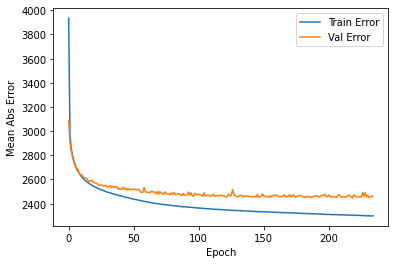

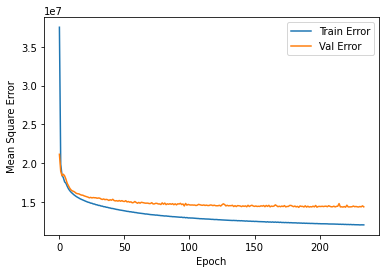

In [117]:
# Plotting our value scores for each epoch:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.plot(hist['epoch'], hist['mae'], label="Train Error")
  plt.plot(hist['epoch'], hist['val_mae'], label="Val Error")
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.show()


  plt.figure()
  plt.plot(hist['epoch'], hist['mse'], label="Train Error")
  plt.plot(hist['epoch'], hist['val_mse'], label="Val Error")
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.show()


plot_history(history)

We can see from the graph that our metric values for the test set didn't improve much after certain number of epochs, thus it was a good idea to set Early Stopping parameter in our model. 

In [121]:
# Creating function to define our model's parameters(with a dropout):
def keras_model3():
  model = keras.Sequential([                           
                            layers.Dense(95, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
                            layers.Dense(95, activation=tf.nn.relu),
                            layers.Dropout(0.2),
                            layers.Dense(1)
                            ])  
  model.compile(loss='mse', optimizer='adam', metrics=['mae','mse', coeff_r2])
  return model

# Assigning our function to our model:
model3 = keras_model3()

# Let's inspect the model:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 95)                9120      
_________________________________________________________________
dense_18 (Dense)             (None, 95)                9120      
_________________________________________________________________
dropout_4 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 96        
Total params: 18,336
Trainable params: 18,336
Non-trainable params: 0
_________________________________________________________________


In [122]:
# Assigning number of epochs:
my_epochs = 1000

# Assigning early stop:
my_early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Fitting our model:
history3 = model3.fit(X_train_scaled, y_train, epochs=my_epochs, validation_split = 0.2, verbose=1, callbacks=[my_early_stop])

Epoch 1/1000
7258/7258 [==============================] - 16s 2ms/step - loss: 38822852.0000 - mae: 4023.2654 - mse: 38822852.0000 - coeff_r2: 0.5706 - val_loss: 21030756.0000 - val_mae: 3067.0320 - val_mse: 21030756.0000 - val_coeff_r2: 0.7680
Epoch 2/1000
7258/7258 [==============================] - 16s 2ms/step - loss: 20992216.0000 - mae: 3069.3640 - mse: 20992216.0000 - coeff_r2: 0.7680 - val_loss: 18926692.0000 - val_mae: 2905.1418 - val_mse: 18926692.0000 - val_coeff_r2: 0.7902
Epoch 3/1000
7258/7258 [==============================] - 16s 2ms/step - loss: 19542786.0000 - mae: 2958.0396 - mse: 19542786.0000 - coeff_r2: 0.7835 - val_loss: 18452394.0000 - val_mae: 2811.8191 - val_mse: 18452394.0000 - val_coeff_r2: 0.7972
Epoch 4/1000
7258/7258 [==============================] - 16s 2ms/step - loss: 19115778.0000 - mae: 2905.3958 - mse: 19115778.0000 - coeff_r2: 0.7884 - val_loss: 18248028.0000 - val_mae: 2789.0869 - val_mse: 18248028.0000 - val_coeff_r2: 0.7985
Epoch 5/1000
7258/72

In [123]:
# Let's see the mean absolute error of the test set (model with a dropout):
loss, mae, mse, r2 = model3.evaluate(X_test_scaled, y_test, verbose=0)

print('The mean absolute error of our model is:', round(mae,2))
print('The mean value of the price column is: ', round(y_test.mean(),2))
print('The test set R^2 of our model is: ', round(r2,4))

The mean absolute error of our model is: 2423.29
The mean value of the price column is:  14204.42
The test set R^2 of our model is:  0.8344


Including the dropout layer has slightly improved our R^2 score, from 0.831 to 0.834. Let's move on with adjusting our layer configurations.

In [130]:
# Creating function to define our model's parameters(with dropout and batch normalization):
def keras_model4():
  model = keras.Sequential([                           
                            layers.Dense(95, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
                            layers.Dense(95, activation=tf.nn.relu),
                            layers.BatchNormalization(),
                            layers.Dropout(0.2),
                            layers.Dense(1)
                            ])  
  model.compile(loss='mse', optimizer='adam', metrics=['mae','mse', coeff_r2])
  return model

# Assigning our function to our model:
model4 = keras_model4()

# Let's inspect the model:
model4.summary()

# Assigning number of epochs:
my_epochs = 1000

# Assigning early stop:
my_early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Fitting our model:
history4 = model4.fit(X_train_scaled, y_train, epochs=my_epochs, validation_split = 0.2, verbose=0, callbacks=[my_early_stop, PrintDot()])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 95)                9120      
_________________________________________________________________
dense_31 (Dense)             (None, 95)                9120      
_________________________________________________________________
batch_normalization_4 (Batch (None, 95)                380       
_________________________________________________________________
dropout_9 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 96        
Total params: 18,716
Trainable params: 18,526
Non-trainable params: 190
_________________________________________________________________

....................................................................................................
........

In [131]:
# Let's see the mean absolute error of the test set (model with a dropout):
loss, mae, mse, r2 = model4.evaluate(X_test_scaled, y_test, verbose=0)

print('The mean absolute error of our model is:', round(mae,2))
print('The mean value of the price column is: ', round(y_test.mean(),2))
print('The test set R^2 of our model is: ', round(r2,4))

The mean absolute error of our model is: 2504.17
The mean value of the price column is:  14204.42
The test set R^2 of our model is:  0.7942


With BatchNormalization layer our score actually dropped. Let's try a different setting.

In [132]:
# Let's see how place of BatchNormalization layer will affect the result (placing it after Dropout layer):

# Creating function to define our model's parameters(with dropout and batch normalization):
def keras_model4():
  model = keras.Sequential([                           
                            layers.Dense(95, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
                            layers.Dense(95, activation=tf.nn.relu),                            
                            layers.Dropout(0.2),
                            layers.BatchNormalization(),
                            layers.Dense(1)
                            ])  
  model.compile(loss='mse', optimizer='adam', metrics=['mae','mse', coeff_r2])
  return model

# Assigning our function to our model:
model4_2 = keras_model4()

# Let's inspect the model:
model4_2.summary()

# Assigning number of epochs:
my_epochs = 1000

# Assigning early stop:
my_early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Fitting our model:
history4 = model4_2.fit(X_train_scaled, y_train, epochs=my_epochs, validation_split = 0.2, verbose=0, callbacks=[my_early_stop, PrintDot()])

# Let's see the mean absolute error of the test set (model with a dropout):
loss, mae, mse, r2 = model4_2.evaluate(X_test_scaled, y_test, verbose=0)

print('The mean absolute error of our model is:', round(mae,2))
print('The mean value of the price column is: ', round(y_test.mean(),2))
print('The test set R^2 of our model is: ', round(r2,4))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 95)                9120      
_________________________________________________________________
dense_34 (Dense)             (None, 95)                9120      
_________________________________________________________________
dropout_10 (Dropout)         (None, 95)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 95)                380       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 96        
Total params: 18,716
Trainable params: 18,526
Non-trainable params: 190
_________________________________________________________________

.........................................................................The mean absolute error of our model is

Rearranging BatchNormalization layer didn't help us much, instead R^2 score has even decreased. It was decided to not use BatchNormalization layer at all.

In [42]:
# Creating function to define our model's parameters(95/190 layers):
def keras_model6():
  model = keras.Sequential([                           
                            layers.Dense(95, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
                            layers.Dense(190, activation=tf.nn.relu),                            
                            layers.Dropout(0.2),
                            layers.Dense(1)
                            ])  
  model.compile(loss='mse', optimizer='adam', metrics=['mae','mse', coeff_r2])
  return model

# Assigning our function to our model:
model6 = keras_model6()

# Let's inspect the model:
model6.summary()

# Assigning number of epochs:
my_epochs = 1000

# Assigning early stop:
my_early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Fitting our model:
history6 = model6.fit(X_train_scaled, y_train, epochs=my_epochs, validation_split = 0.2, verbose=0, callbacks=[my_early_stop, PrintDot()])

# Let's see the mean absolute error of the test set (model with a dropout):
loss, mae, mse, r2 = model6.evaluate(X_test_scaled, y_test, verbose=0)
print()
print('The mean absolute error of our model is:', round(mae,2))
print('The mean value of the price column is: ', round(y_test.mean(),2))
print('The test set R^2 of our model is: ', round(r2,4))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 95)                9120      
_________________________________________________________________
dense_4 (Dense)              (None, 190)               18240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 190)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 191       
Total params: 27,551
Trainable params: 27,551
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
....................................................................................................
.............................................

In [44]:
# Creating function to define our model's parameters(with a dropout 0.5):
def keras_model7():
  model = keras.Sequential([                           
                            layers.Dense(95, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
                            layers.Dense(190, activation=tf.nn.relu),
                            layers.Dropout(0.5),
                            layers.Dense(1)
                            ])  
  model.compile(loss='mse', optimizer='adam', metrics=['mae','mse', coeff_r2])
  return model

# Assigning our function to our model:
model7 = keras_model7()

# Let's inspect the model:
model7.summary()

# Assigning number of epochs:
my_epochs = 1000

# Assigning early stop:
my_early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Fitting our model:
history7 = model7.fit(X_train_scaled, y_train, epochs=my_epochs, validation_split = 0.2, verbose=0, callbacks=[my_early_stop, PrintDot()])

# Let's see the mean absolute error of the test set (model with a dropout):
loss, mae, mse, r2 = model7.evaluate(X_test_scaled, y_test, verbose=0)
print()
print('The mean absolute error of our model is:', round(mae,2))
print('The mean value of the price column is: ', round(y_test.mean(),2))
print('The test set R^2 of our model is: ', round(r2,4))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 95)                9120      
_________________________________________________________________
dense_10 (Dense)             (None, 190)               18240     
_________________________________________________________________
dropout_2 (Dropout)          (None, 190)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 191       
Total params: 27,551
Trainable params: 27,551
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
....................................................................................................
.............................................

It seems that with a droput value of 0.2 our score was slightly better, 0.8366 vs 0.8326 (at dropout=0.5).

In [46]:
# Creating function to define our model's parameters(with some more layers):
def keras_model8():
  model = keras.Sequential([                           
                            layers.Dense(95, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
                            layers.Dense(190, activation=tf.nn.relu),
                            layers.Dropout(0.2),
                            layers.Dense(190, activation=tf.nn.relu),
                            layers.Dropout(0.2),
                            layers.Dense(190, activation=tf.nn.relu),
                            layers.Dropout(0.2),
                            layers.Dense(1)
                            ])  
  model.compile(loss='mse', optimizer='adam', metrics=['mae','mse', coeff_r2])
  return model

# Assigning our function to our model:
model8 = keras_model8()

# Let's inspect the model:
model8.summary()

# Assigning number of epochs:
my_epochs = 1000

# Assigning early stop:
my_early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Fitting our model:
history8 = model8.fit(X_train_scaled, y_train, epochs=my_epochs, validation_split = 0.2, verbose=0, callbacks=[my_early_stop, PrintDot()])

# Let's see the mean absolute error of the test set (model with a dropout):
loss, mae, mse, r2 = model8.evaluate(X_test_scaled, y_test, verbose=0)
print()
print('The mean absolute error of our model is:', round(mae,2))
print('The mean value of the price column is: ', round(y_test.mean(),2))
print('The test set R^2 of our model is: ', round(r2,4))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 95)                9120      
_________________________________________________________________
dense_18 (Dense)             (None, 190)               18240     
_________________________________________________________________
dropout_6 (Dropout)          (None, 190)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 190)               36290     
_________________________________________________________________
dropout_7 (Dropout)          (None, 190)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 190)               36290     
_________________________________________________________________
dropout_8 (Dropout)          (None, 190)              

We can see that with more hidden layers there is a slight increase in R^2 score (0.838 vs 0.836), although much more time was needed to compute the model.

Out of all the models, the best was found to be XGBRegressor model (in my 1st notebook) with a MAE of 1,586 (for the mean price of \\$14,255) and an R^2 value of 0.91.

I would also like to note that, as it was already mentioned before, these metric values (MAE and R^2) could be improved by further limiting the scope of numerical columns, like `year` and `odometer`, to have even better distribution (closer to standard distribution), but in that case, the tree-based model implementation would be limited to those min and max values that the model had seen. The initial goal was not just to get the best possible results out of the model, but also build a practically beneficial model.